In [21]:
import pypsa
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy
import matplotlib.ticker as ticker

In [22]:
model = pypsa.Network('C:/Users/hie/pe_tan/pypsa-earth/results/2040_base/networks/elec_s_all_ec_lcopt_1h.nc')

regions_onshore = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/shapes/country_shapes.geojson")
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


In [23]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'


custom_colors = {
    "Biomass": "#0c6013",
    "Hydropower": teal4,
    'Reservoir & Dam': teal4,
    'Run of River': 'lightsteelblue',
    "Hydro": teal4,
    "Natural Gas": brown2,
    "Natural gas": brown2,
    'Combined-Cycle Gas': brown2,
    "CCGT": brown2,
    "Open-Cycle Gas": brown,
    "Diesel and HFO": grey4,
    "Oil": grey4,
    "Solar Pv": "#f9d002",
    "Solar": "#f9d002",
    "Wind": teal2,
    "Onshore Wind": teal2,
    "Coal": "#707070",
    "Biofuels": "#06540d",
    "Kerosene": grey4,
    "Electricity": yellow,
    "Charcoal": brown2,
    "Gas": beige1,
    "Other": teal1,
    "Geothermal": teal3,
}

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:13: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:19: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:26: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_24916\4125654604.py:31: FutureWarning:

DataFrame.groupby with axis=1 is depre

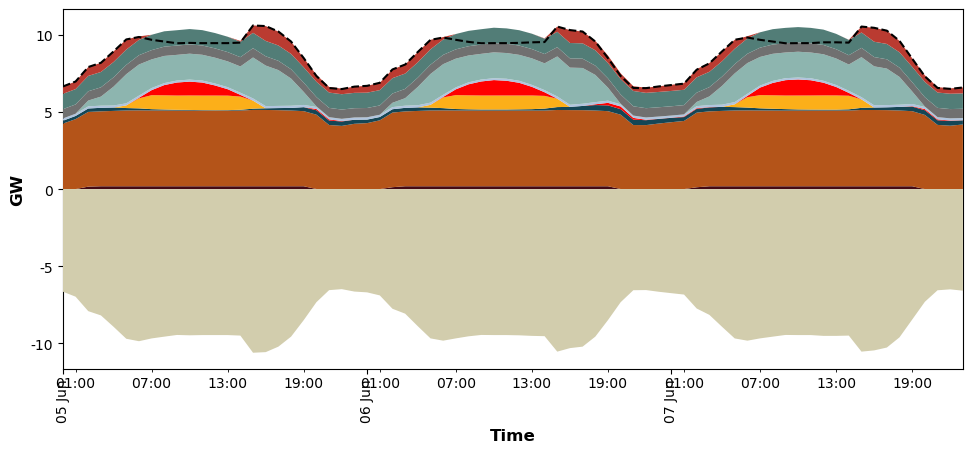

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  5.025265e+03
OCGT        1.850000e+02  1.850000e+02
coal        6.000000e+02  6.020860e+02
geothermal  1.350000e+02  9.950000e+02
load        6.700000e+10  6.700000e+10
onwind      9.110670e-01  1.370000e+03
ror         6.017862e+02  6.017862e+02
solar       1.447219e+01  3.000000e+03

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-06-05"
second_date = "2013-06-07"

#Hourly solar curtailment calculation
maximum_solar_generation = model.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * model.generators.loc[[idx for idx in model.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = model.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * model.generators.loc[[idx for idx in model.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar.loc[first_date:second_date] + curtailment_wind.loc[first_date:second_date]

#Hourly generation per technology
OCGT = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["OCGT"]
Onwind = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["onwind"]
solar = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["solar"]


#LoadShedding
load = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = model.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = OCGT.shape[0]

if "ror" in model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum().columns:
    ror = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    

    
if "CCGT" in model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum().columns:
    CCGT = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum().columns:
    load = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

if "coal" in model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum().columns:
    coal = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["coal"]

if not model.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = model.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum().columns:
    geothermal = model.generators_t.p.loc[first_date:second_date].groupby(model.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)



# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

model.carriers.color['geothermal'] = teal3
model.carriers.color['ror'] = teal4
model.carriers.color['hydro'] = teal4
model.carriers.color['coal'] = "#707070"
model.carriers.color['CCGT'] = brown2
model.carriers.color['OCGT'] = brown
#model.carriers.color['oil'] = beige1
model.carriers.color['onwind'] = teal2
model.carriers.color['solar'] = yellow
OCGT_color=brown
CCGT_color=brown2
Onwind_color=teal2
Solar_color=yellow
curtailment_color = 'red'
ror_color='lightsteelblue'
reservoir_color=teal4
coal_color="#707070"

demand_color=beige3
geothermal_color = teal3
lostload_color = red2

A = plt.stackplot(OCGT.index, OCGT, CCGT, Onwind, solar, curtailment, ror,reservoir, coal,  geothermal,load,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,curtailment_color,ror_color,reservoir_color,coal_color,geothermal_color,lostload_color], zorder = 3)
plt.stackplot(OCGT.index,demand, colors=[demand_color], zorder = 3)
plt.xticks(rotation = 90)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# Set the x-axis major formatter to display days and months
myFmt = mdates.DateFormatter('%d %b')  # Example: "07 May"
ax.xaxis.set_major_formatter(myFmt)

# Set the x-axis minor formatter to display hours
hourFmt = mdates.DateFormatter('%H:%M')  # Example: "14:00"
ax.xaxis.set_minor_formatter(hourFmt)
ax.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks for each day
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))  # Minor ticks every 6 hours
ax.set_xlim(pd.Timestamp("2013-06-05 00:00"), pd.Timestamp("2013-06-07 23:00"))

ax.set_ylabel('GW',fontsize=12,fontweight='bold')
ax.set_xlabel('Time', fontsize=12,fontweight='bold')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')

load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')
lostload_patch = mpatches.Patch(color=lostload_color, label ='Lost load')
coal_patch = mpatches.Patch(color=coal_color, label ='Coal')

handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,curtailment_patch,ror_patch,reservoir_patch,geothermal_patch,lostload_patch,load_patch,coal_patch]

#ax.legend(handles=handles, ncol=6, loc="upper center", bbox_to_anchor=(0.5, -0.25))

image_format = 'eps' # e.g .png, .svg, etc.

demand = model.loads_t.p_set.loc[first_date:second_date].sum(axis=1)

# Plot the demand as a time series
plt.plot(demand.abs(), color="black", label="abs(withdrawal)", linestyle="dashed", zorder=100)
#fig.savefig(r'C:\Users\Carlos\Desktop\satand_alone_transition.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = model.generators.groupby(["carrier"]).sum()
sto_cap = model.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(model.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(model.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

In [25]:
lines = model.lines
buses = model.buses
generators = model.generators
generators_t = model.generators_t
load=model.loads
buses=model.buses





In [26]:
#model.export_to_csv_folder('C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base')

In [27]:
# import matplotlib.pyplot as plt

# # Handle missing values in carrier columns
# model.generators['carrier'] = model.generators['carrier'].fillna('Unknown').astype(str)
# model.storage_units['carrier'] = model.storage_units['carrier'].fillna('Unknown').astype(str)

# # Calculate dispatch for generators (grouped by carrier)
# generator_dispatch = model.generators_t.p.sum() / 1e6 * 8760  # Convert to TWh
# generator_dispatch_by_carrier = generator_dispatch.groupby(model.generators.carrier).sum()

# # Calculate dispatch for storage units (grouped by carrier)
# storage_dispatch = model.storage_units_t.p.sum() / 1e6 * 8760  # Convert to TWh
# storage_dispatch_by_carrier = storage_dispatch.groupby(model.storage_units.carrier).sum()

# # Combine generator and storage dispatch
# total_dispatch = generator_dispatch_by_carrier+storage_dispatch_by_carrier

# # Plot the pie chart
# plt.figure(figsize=(10, 8))
# total_dispatch.plot.pie(
#     autopct='%1.1f%%',
#     startangle=90,
#     counterclock=False,
#     ylabel="",
#     title="Dispatch by Carrier and Storage Units (TWh)"
# )
# plt.show()

In [28]:
model.statistics()
#model.export_to_csv_folder('C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/statistics') 

Optimal Capacity  Installed Capacity  \
Generator   Coal                    6.020860e+02        6.000000e+02   
            Combined-Cycle Gas      5.025265e+03        1.192700e+03   
            Geothermal              9.950000e+02        1.350000e+02   
            Onshore Wind            1.370000e+03        9.110670e-01   
            Open-Cycle Gas          1.850000e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   3.000000e+03        1.447219e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      6.159941e+04        3.477151e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Coal                5.269048e+06  0.000000e+00  5.269048e+06   
            Combined-Cycle Gas  3.549498e+07  0.000000e+00  3.549498e+07   
            Geothermal          8.707822e+06  0.000000e+00  8.707822e+06   
            Onshore Wind        9.130155e+05  0.000000e+00  9.130155e+05   
            Open-Cycle Gas      4.066085e+05  0.000000e+00  4.066085e+05   
            Run of River        2.920437e+06  0.000000e+00  2.920437e+06   
            Solar               3.118284e+06  0.000000e+00  3.118284e+06   
            load                3.720686e+06  0.000000e+00  3.720686e+06   
Line        AC                  2.596753e+08  2.596753e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.829911e+07  0.000000e+00  1.829911e+07   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Coal                0.000000e+00         0.999009  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.806314  0.000000e+00   
            Geothermal          0.000000e+00         0.999039  0.000000e+00   
            Onshore Wind        0.000000e+00         0.076077  2.341991e+05   
            Open-Cycle Gas      0.000000e+00         0.250900  0.000000e+00   
            Run of River        0.000000e+00         0.553989  6.475558e+04   
            Solar               0.000000e+00         0.118656  1.259542e+06   
            load                0.000000e+00         0.000006  0.000000e+00   
Line        AC                  6.252681e+06         0.481227  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.481253  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Coal                       2.658205e+08             1.697815e+08   
            Combined-Cycle Gas         6.340972e+08             1.661625e+09   
            Geothermal                 0.000000e+00             8.239555e+04   
            Onshore Wind               1.775253e+08             2.227277e+04   
            Open-Cycle Gas             1.090340e+07             2.630498e+07   
            Run of River               2.465120e+08             3.005263e+04   
            Solar                      1.448679e+08             6.069149e+04   
            load                       0.000000e+00             2.976552e+13   
Line        AC                         3.417679e+08             0.000000e+00   
Load        -                          0.000000e+00             0.000000e+00   
StorageUnit Reservoir & Dam            0.000000e+00             1.777125e+05   

                                     Revenue  Market Value  
Generator   Coal                3.255892e+08  6.179280e+01  
            Combined-Cycle Gas  2.295340e+09  6.466659e+01  
            Geothermal          5.642493e+08  6.479799e+01  
            Onshore Wind        4.558139e+12  4.992400e+06  
            Open-Cycle Gas      4.18352

In [29]:
model.generators

,carrier,bus,p_nom_min,p_nom,p_nom_extendable,efficiency,marginal_cost,capital_cost,build_year,lifetime,...,q_set,marginal_cost_quadratic,committable,start_up_cost,shut_down_cost,stand_by_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
C31,CCGT,2,102.0,1.020000e+02,True,0.58,46.813041,126181.845894,2007,20.0,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
C32,CCGT,2,189.0,1.890000e+02,True,0.58,46.813913,126181.845894,2006,20.0,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
C33,CCGT,2,129.0,1.290000e+02,True,0.58,46.812501,126181.845894,2011,25.0,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
C34,CCGT,2,150.0,1.500000e+02,True,0.58,46.812533,126181.845894,2015,25.0,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
C35,CCGT,2,248.2,2.482000e+02,True,0.58,46.813154,126181.845894,2018,-5.0,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80 load,load,80,0.0,1.000000e+09,False,1.00,8000.010980,0.000000,0,inf,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
81 load,load,81,0.0,1.000000e+09,False,1.00,8000.009587,0.000000,0,inf,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0
82 load,load,82,0.0,1.000000e+09,False,1.00,8000.009900,0.000000,0,inf,...,0.0,0.0,False,0.0,0.0,0.0,NaN,NaN,1.0,1.0


In [30]:
grouped_generators=model.generators.groupby(by=model.generators.p_nom).sum()
grouped_generators

,carrier,bus,p_nom_min,p_nom_extendable,efficiency,marginal_cost,capital_cost,build_year,lifetime,p_nom_max,...,q_set,marginal_cost_quadratic,committable,start_up_cost,shut_down_cost,stand_by_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
p_nom,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,onwindonwindonwindonwindonwindonwindonwindonwi...,2471012151618202122232529303132333435363738404...,0.000000,87,87.00,2.045218,9.241226e+06,0,inf,9.737407e+05,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,87.0,87.0
1.001129e-01,solar,69,0.100113,1,1.00,0.020724,4.828930e+04,0,inf,8.712668e+03,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1.056758e-01,solar,23,0.105676,1,1.00,0.019819,4.828930e+04,0,inf,8.842307e+03,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1.139728e-01,solar,18,0.113973,1,1.00,0.019674,4.828930e+04,0,inf,1.009739e+04,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1.195508e-01,solar,53,0.119551,1,1.00,0.020509,4.828930e+04,0,inf,1.049737e+04,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.890000e+02,CCGT,2,189.000000,1,0.58,46.813913,1.261818e+05,2006,20.0,inf,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2.482000e+02,CCGT,2,248.200000,1,0.58,46.813154,1.261818e+05,2018,-5.0,inf,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3.000000e+02,CCGT,40,300.000000,1,0.58,46.813381,1.261818e+05,2026,25.0,inf,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [31]:
grouped_generators=model.generators.groupby(by=model.generators.carrier).sum()
#grouped_generators.export_to_csv_folder('C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base')

In [32]:
total_p_nom = model.generators['p_nom'].sum()
total_p_nom

67000002729.8695

In [33]:
print(model.loads_t.p_set.sum())

Load
0     5.081585e+06
3     1.480400e+06
5     1.925935e+05
8     1.718848e+06
9     3.406932e+05
          ...     
80    6.227415e+05
81    2.703821e+06
82    5.815727e+04
83    4.994499e+05
84    2.191536e+06
Length: 67, dtype: float64


<AxesSubplot:xlabel='snapshot', ylabel='MW'>

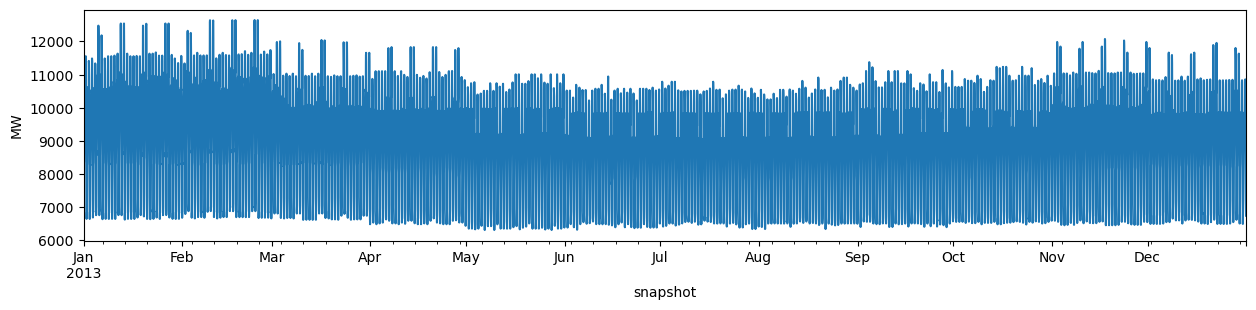

In [34]:
model.loads_t.p_set.sum(axis=1).plot(figsize=(15,3), ylabel="MW")

In [52]:
model.loads_t.p.sum().sum()/1e6

78.84999999998801

In [36]:
model.iplot(mapbox='osm')

{'data': [Scattermapbox({
      'lat': [-6.7116, -6.6413],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.7439, 38.3689],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-5.3126, -4.0717],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.6298, 37.7377],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-4.8396, -3.6219],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.7573, 33.5148],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-8.8482, -8.9146],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.8061, 33.4967],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.6219, -3.2208],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [33.5148, 32.4905],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.861, -3.6219],
      'line': {'color'

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



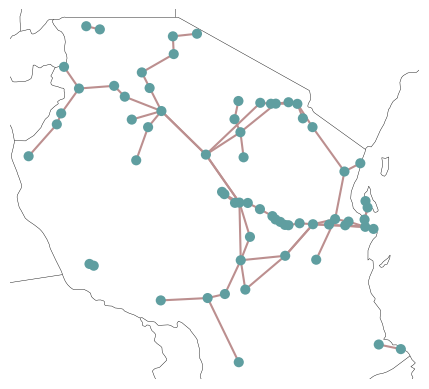

In [37]:
model.plot();


In [38]:
for c in model.iterate_components(list(model.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 67 entries
Component 'Carrier' has 13 entries
Component 'Line' has 73 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 67 entries
Component 'Generator' has 232 entries
Component 'StorageUnit' has 16 entries


In [39]:
model.lines

,v_nom,bus0,bus1,length,dc,geometry,bounds,carrier,type,s_max_pu,...,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
0,380.0,21,29,43.985476,False,"MULTILINESTRING ((38.7439 -6.7116, 38.74378869...",MULTIPOINT ((38.357321400000096 -6.63929209999...,AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
1,380.0,36,30,181.143759,False,MULTILINESTRING ((38.61499740000011 -5.2978653...,MULTIPOINT ((37.73768980000001 -4.071734399999...,AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,380.0,27,12,221.213747,False,"LINESTRING (34.7563 -4.8406, 34.75503799999999...","MULTIPOINT ((34.7563 -4.8406), (33.5148 -3.6219))",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,380.0,42,8,161.020453,False,MULTILINESTRING ((33.49678590000009 -8.9145849...,"MULTIPOINT ((33.4967 -8.9146), (33.49678590000...",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,380.0,12,35,129.558873,False,MULTILINESTRING ((32.49089980000009 -3.2207166...,"MULTIPOINT ((32.4905 -3.2208), (32.49089980000...",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,380.0,73,84,16.178887,False,MULTILINESTRING ((31.504323200000012 -7.895004...,"MULTIPOINT ((31.5043 -7.895), (31.504323200000...",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
69,380.0,74,83,36.740825,False,"MULTILINESTRING ((30.5913 -3.9936, 30.59131800...","MULTIPOINT ((30.5913 -3.9936), (30.7134 -3.687...",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
70,380.0,75,57,15.448316,False,"MULTILINESTRING ((36.6172 -6.5587, 36.61727609...","MULTIPOINT ((36.6172 -6.5587), (36.61727609999...",AC,Al/St 240/40 4-bundle 380.0,0.9,...,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [40]:
model.storage_units

,carrier,bus,p_nom,max_hours,p_min_pu,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,marginal_cost,build_year,...,sign,marginal_cost_quadratic,capital_cost,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
0 hydro,hydro,33,200.000000,212.872523,0.0,0.9,0.0,True,0.009920,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
2 hydro,hydro,16,80.000000,212.872523,0.0,0.9,0.0,True,0.010793,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
4 hydro,hydro,49,7.125972,212.872523,0.0,0.9,0.0,True,0.009380,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
6 hydro,hydro,71,2115.000000,212.872523,0.0,0.9,0.0,True,0.009412,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
7 hydro,hydro,80,27.000000,212.872523,0.0,0.9,0.0,True,0.010034,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
8 hydro,hydro,81,300.000000,212.872523,0.0,0.9,0.0,True,0.009139,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
9 hydro,hydro,23,358.000000,212.872523,0.0,0.9,0.0,True,0.010517,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
11 hydro,hydro,8,90.100000,212.872523,0.0,0.9,0.0,True,0.010609,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
12 hydro,hydro,8,81.600000,212.872523,0.0,0.9,0.0,True,0.010784,0,...,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0


Time varying components

<AxesSubplot:xlabel='snapshot'>

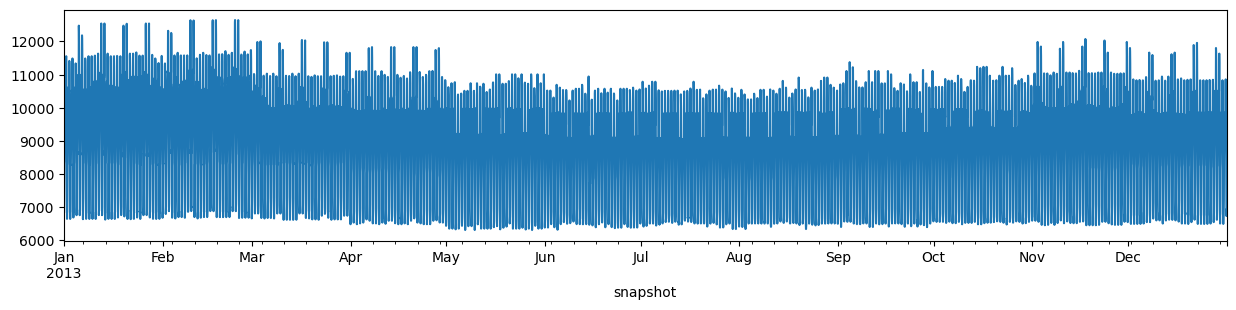

In [41]:
model.loads_t.p_set.sum(axis=1).plot(figsize=(15,3))  

Total annual system costs

In [42]:
model.objective/1e6 #million euroes per year

29768312.371530987

Transmission line expansion

In [43]:
model.lines.s_nom   #lines nominal capacities

Line
0      147.466806
1      147.466806
2      491.556019
3      491.556019
4      491.556019
         ...     
68      53.728216
69    1787.476433
70     491.556019
71     491.556019
72     147.466806
Name: s_nom, Length: 73, dtype: float64

In [44]:
model.lines.s_nom_opt #optimized transmission capacity expansion by x 

Line
0      731.615373
1      278.988852
2      947.361429
3      491.565860
4     1080.595784
         ...     
68     423.000780
69    1799.961071
70     723.576210
71    1644.828433
72     604.063515
Name: s_nom_opt, Length: 73, dtype: float64

Optimal generator/storage

In [45]:
model.generators.groupby ('carrier').p_nom_opt.sum() #MW

carrier
CCGT          5.025265e+03
OCGT          1.850000e+02
coal          6.020860e+02
geothermal    9.950000e+02
load          6.700000e+10
onwind        1.370000e+03
ror           6.017862e+02
solar         3.000000e+03
Name: p_nom_opt, dtype: float64

In [46]:
model.storage_units.groupby ('carrier').p_nom_opt.sum() #MW

carrier
hydro    4340.625972
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

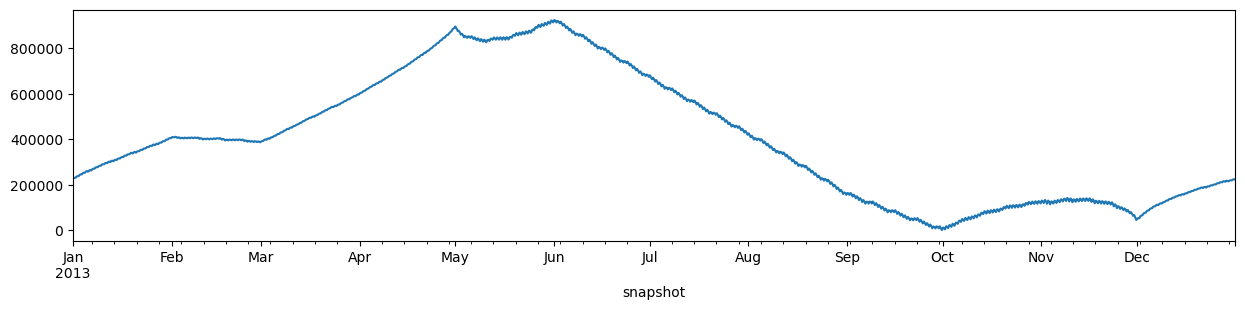

In [47]:
(model.storage_units_t.state_of_charge.filter(like='hydro',axis=1).sum(axis=1)).plot(figsize=(15,3))

In [48]:
#lost load
# Calculate lost load
lost_load = model.generators_t.p.loc[:, model.generators[model.generators.carrier == "load"].index]

# Total lost load over the entire period (in MWh)
total_lost_load = lost_load.sum().sum()

# Peak lost load (maximum lost load at any time snapshot)
peak_lost_load = lost_load.max().max()

# Print results
print(f"Total Lost Load: {total_lost_load:.2f} MWh")
print(f"Peak Lost Load: {peak_lost_load:.2f} MW")

Total Lost Load: 3720685831.01 MWh
Peak Lost Load: 630322.13 MW


In [49]:
# Group lost load by bus
lost_load_by_bus = lost_load.sum(axis=0).groupby(model.generators.loc[model.generators.carrier == "load", "bus"]).sum()

# Print top buses with the highest lost load
print("Top buses by lost load:")
print(lost_load_by_bus.sort_values(ascending=False).head(10))

Top buses by lost load:
bus
73    2.097913e+09
18    7.193533e+08
38    3.612496e+08
62    2.955199e+08
20    1.013960e+08
55    8.698395e+07
84    3.744923e+07
56    2.082063e+07
49    1.054058e+01
74    1.034440e+01
dtype: float64


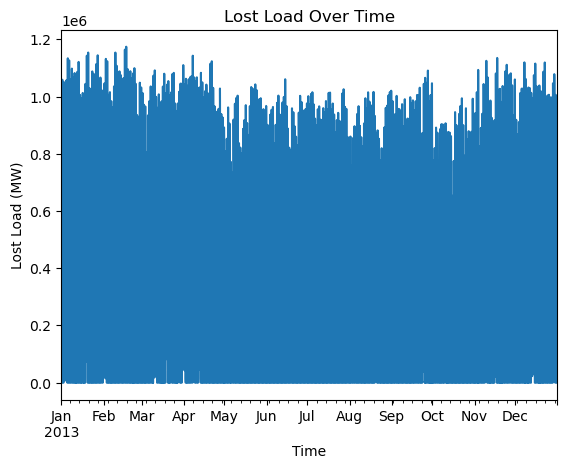

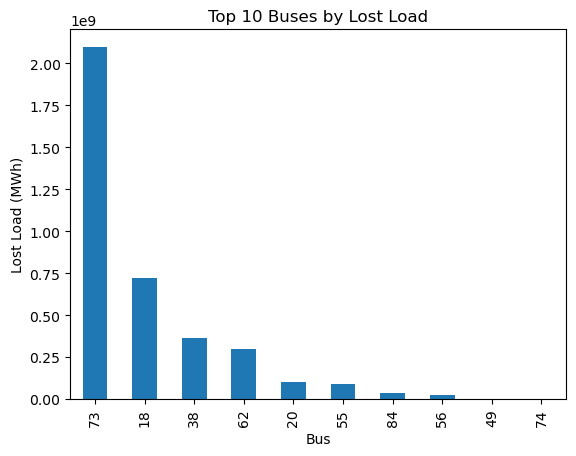

In [50]:
import matplotlib.pyplot as plt

#lost load over time
lost_load.sum(axis=1).plot(title="Lost Load Over Time", ylabel="Lost Load (MW)", xlabel="Time")
plt.show()

#lost lost per bus

lost_load_by_bus.sort_values(ascending=False).head(10).plot(kind="bar", title="Top 10 Buses by Lost Load", ylabel="Lost Load (MWh)", xlabel="Bus")
plt.show()

In [51]:
#peak generation

# Calculate total generation at each time step
total_generation = model.generators_t.p.sum(axis=1)

# Find the peak generation and its timestamp
peak_generation = total_generation.model.model.max()
peak_generation_time = total_generation.model.model.idxmax()

# Print results
print(f"Peak generation: {peak_generation:.2f} MW")
print(f"Time of peak generation: {peak_generation_time}")


# Plot total generation over time
total_generation.model.plot(title="Total Generation Over Time", ylabel="Generation (MW)", xlabel="Time")


AttributeError: 'Series' object has no attribute 'model'

Peak demand: 12645.10 MW
Time of peak demand: 2013-02-23 16:00:00


<AxesSubplot:title={'center':'Total Demand Over Time'}, xlabel='Time', ylabel='Generation (MW)'>

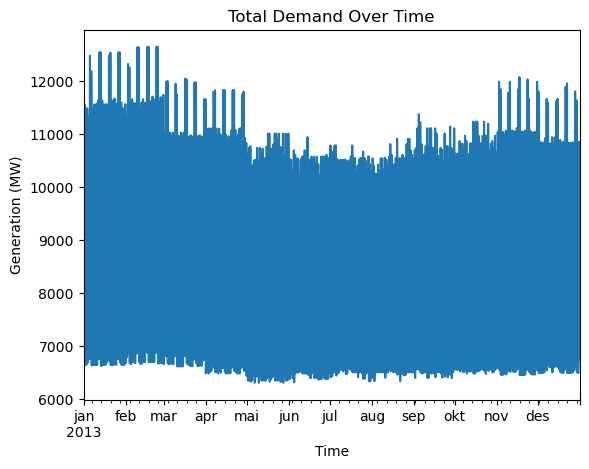

In [ ]:
#peak demand
# Calculate total demand at each time step
total_demand = model.loads_t.p_set.sum(axis=1)

# Find the peak demand and its timestamp
peak_demand = total_demand.max()
peak_demand_time = total_demand.idxmax()

# Print results
print(f"Peak demand: {peak_demand:.2f} MW")
print(f"Time of peak demand: {peak_demand_time}")

# Plot total generation over time
total_demand.plot(title="Total Demand Over Time", ylabel="Generation (MW)", xlabel="Time")

Plotting networks with line loading

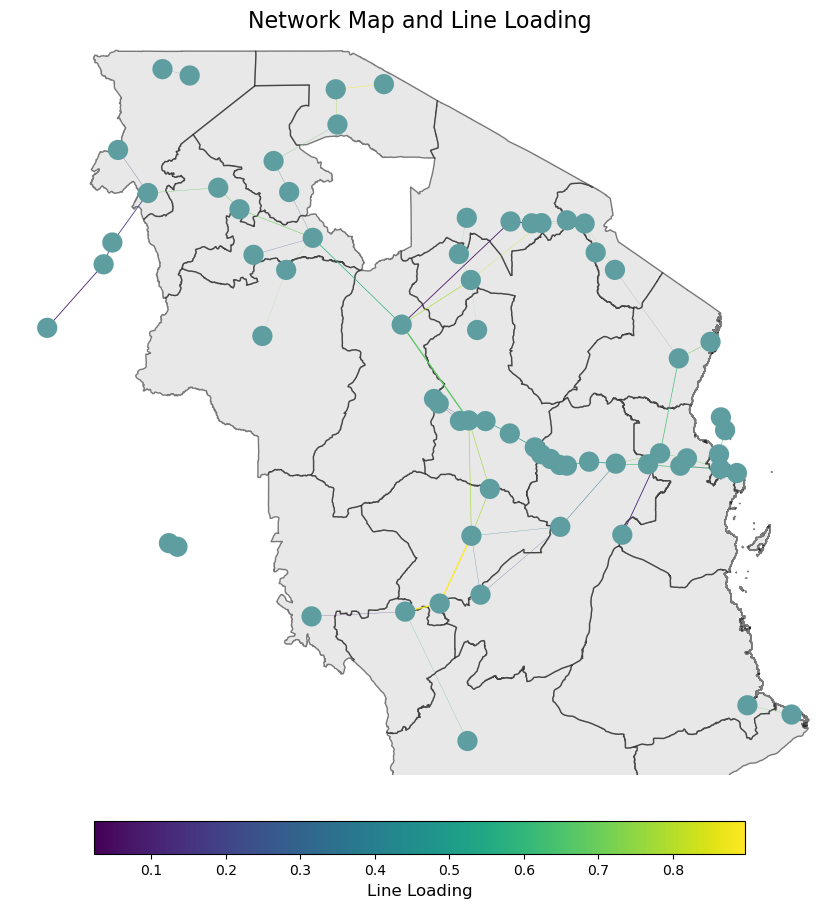

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Load GADM shapefile
gadm_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/bus_regions/regions_onshore_elec_s_all.geojson"  # Replace with the actual path
gadm = gpd.read_file(gadm_path)

# Calculate line loading
loading = (
    (model.lines_t.p0.abs().mean().reindex(model.lines.index, fill_value=0) / 
    (model.lines.s_nom_opt * model.lines.s_max_pu).reindex(model.lines.index, fill_value=0))
    .fillna(0)
)



# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.Mercator()})

# Plot the GADM shapefile
gadm.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5, transform=ccrs.PlateCarree())

# Plot the network
model.plot(
    ax=ax,
    branch_components=["Line"],  # Plot only lines
    line_widths=model.lines.s_nom_opt / 3e3,  # Scale line widths
    line_colors=loading,  # Color lines by loading
    color_geomap=False,  # Do not recolor the background
)

# Customize the plot
ax.set_title("Network Map and Line Loading", fontsize=16)
ax.axis("off")  # Turn off axis

# Add a colorbar for line loading
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=loading.min(), vmax=loading.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7)
cbar.set_label("Line Loading", fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Normalize bus sizes based on load data
bus_sizes = model.loads_t.p_set.sum().rename("load").rename_axis("bus")

# Ensure bus_sizes indices align with model.buses.index
bus_sizes = bus_sizes[bus_sizes.index.isin(model.buses.index)]

# Normalize node sizes
bus_sizes = normalize_node_size(bus_sizes)

# Plot the network
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},  # PlateCarree(default), Mercator, Orthographic
)

model.plot(
    margin=0.1,
    ax=ax,  # Pass the axis to the plot function
    geomap=True,  # Enable geographic map
    projection=None,  # Use the default projection
    bus_colors="cadetblue",  # Color for buses
    bus_alpha=1,  # Transparency for buses
    bus_sizes=bus_sizes,  # Normalized bus sizes
    bus_cmap=None,  # No colormap for buses
    line_colors="rosybrown",  # Color for lines
    link_colors="darkseagreen",  # Color for links
    transformer_colors="orange",  # Color for transformers
    line_widths=model.lines.s_nom_opt / 3e2,  # Scale line widths
    link_widths=1.5,  # Fixed link widths
    transformer_widths=1.5,  # Fixed transformer widths
    line_cmap=None,  # No colormap for lines
    link_cmap=None,  # No colormap for links
    transformer_cmap=None,  # No colormap for transformers
    flow=None,  # No flow data
    branch_components=None,  # Use default branch components
    layouter=None,  # Use default layout
    title="",  # No title
    boundaries=None,  # Use default boundaries
    geometry=False,  # Disable geometry plotting
    jitter=None,  # No jitter
    color_geomap=True,  # Enable geographic map coloring
)

# Turn off the axis
ax.axis("off")

# Show the plot
plt.show()

NameError: name 'normalize_node_size' is not defined

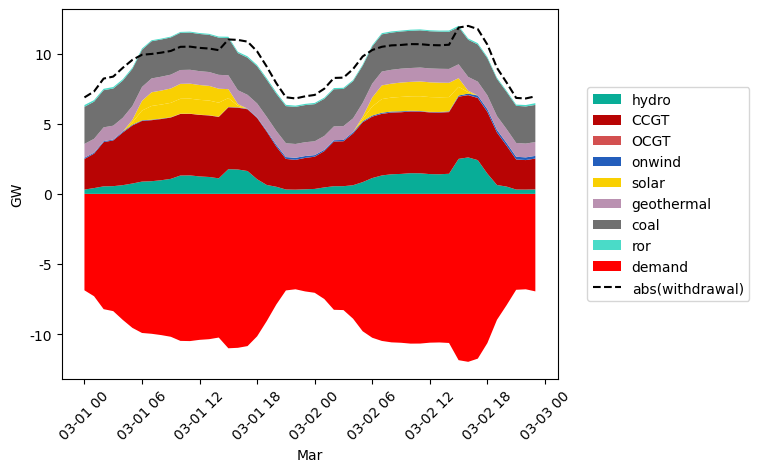

In [ ]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'


custom_colors = {
    "Biomass": "#0c6013",
    "Hydropower": teal4,
    'Reservoir & Dam': teal4,
    'Run of River': teal4,
    "Hydro": teal4,
    "Natural Gas": brown2,
    "Natural gas": brown2,
    'Combined-Cycle Gas': brown2,
    "CCGT": brown2,
    "Open-Cycle Gas": brown,
    "Diesel and HFO": grey4,
    "Oil": grey4,
    "Solar Pv": "#f9d002",
    "Solar": "#f9d002",
    "Wind": teal2,
    "Onshore Wind": teal2,
    "Coal": "#707070",
    "Biofuels": "#06540d",
    "Kerosene": grey4,
    "Electricity": yellow,
    "Charcoal": brown2,
    "Gas": beige1,
    "Other": teal1,
    "Geothermal": teal3,
}

#dispatch optimized sustem
# 
first_date = "2013-03-01"
second_date = "2013-03-02"
CCGT = model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["CCGT"]
OCGT = model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["OCGT"]
Onwind = model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["onwind"]
solar = model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["solar"]
geothermal= model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["geothermal"]
coal = model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["coal"]

ror= model.generators_t.p.loc[first_date:second_date].T.groupby(model.generators.carrier).sum().loc["ror"]


hydro = model.storage_units_t.p.loc[first_date:second_date].T.groupby(model.storage_units.carrier).sum().loc["hydro"]

demand = model.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

# names for labels
demand.name = "demand"

fig, ax=plt.subplots()
 
plt.stackplot(
    CCGT.index,
    supply:=(hydro.where(hydro > 0, 0), CCGT, OCGT, Onwind,  solar, solar, geothermal,  coal, ror), 
    labels=[key.name for key in supply],
    colors=[model.carriers.color.get(source.name, default="gray") for source in supply], 
    zorder = 99
)
plt.stackplot(
    CCGT.index,
    withdrawal:=(demand, hydro.where(hydro < 0, 0)),
    labels=[source.name for source in withdrawal],
    colors=[model.carriers.color.get(key.name, default="red") for key in withdrawal], 
    zorder = 1
)
plt.plot(sum(withdrawal).abs(), color = "black", label="abs(withdrawal)", linestyle="dashed", zorder=100)


plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#myFmt = mdates.DateFormatter("%d")
#ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel("GW")
ax.set_xlabel("Mar")

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # remove duplicates

plt.legend(unique_labels.values(), unique_labels.keys(), loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.show()
#fig.savefig("path")

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



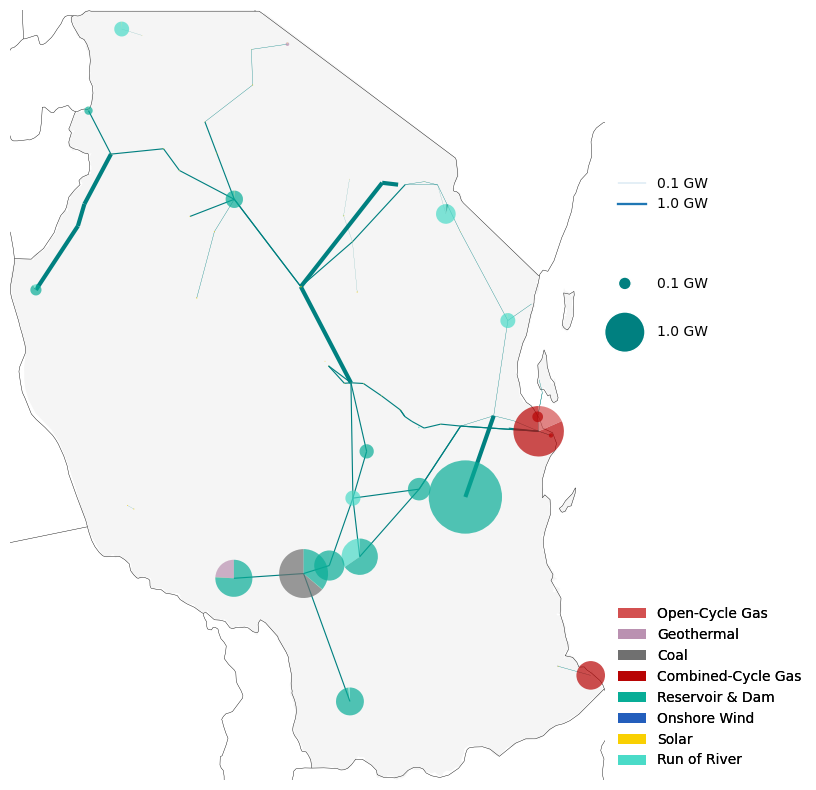

In [ ]:
# CURRENT SYSTEM##
# # Filter carriers to include only those present in the model
present_carriers = set(model.generators.carrier.unique()).union(model.storage_units.carrier.unique())
filtered_carriers = model.carriers[model.carriers.index.isin(present_carriers)]

# Scale settings
bus_scale = 6e3 
line_scale = 6e2

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

#model.carriers.drop("load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(model.buses.x.mean())})
gen = model.generators[model.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = model.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    model.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=model.lines.s_nom/ line_scale,
        link_widths=model.links.p_nom/ line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

# Add legend circles with custom colors using patch_kw
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
    patch_kw={"facecolor": "teal", "edgecolor": "white"}  # Custom colors
)

add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
    #patch_kw={"facecolor": "teal"},  # Custom colors
)
add_legend_patches(
    ax,
    filtered_carriers.color,
    filtered_carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



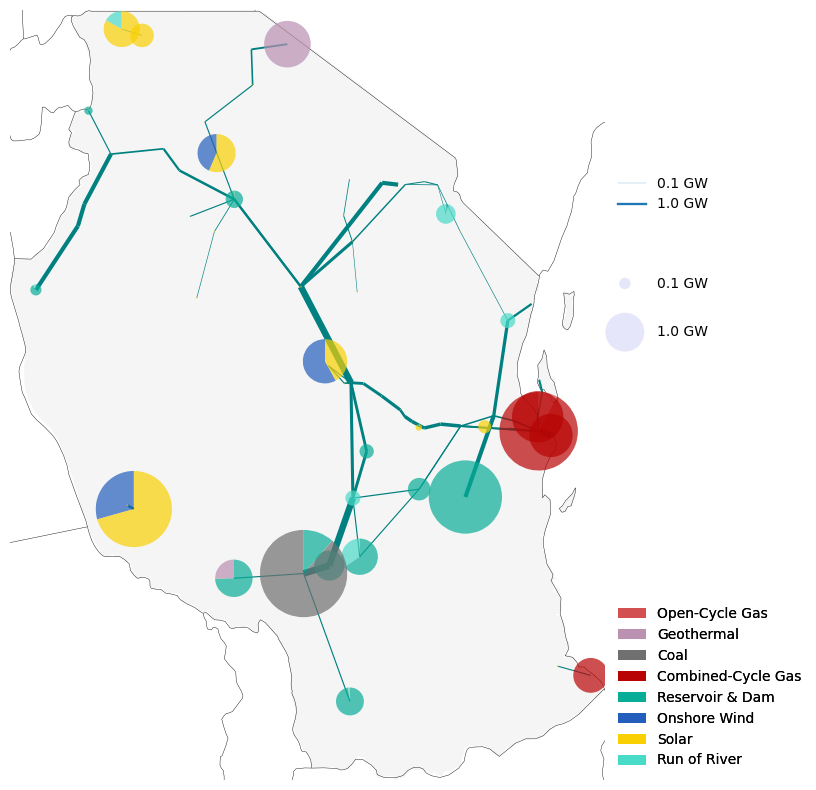

In [ ]:
##FUTURE OPTIMIZED SYSTEM###

# Filter carriers to include only those present in the model
present_carriers = set(model.generators.carrier.unique()).union(model.storage_units.carrier.unique())
filtered_carriers = model.carriers[model.carriers.index.isin(present_carriers)]

# Plot the network
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(model.buses.x.mean())})
gen = model.generators[model.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = model.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    model.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=model.lines.s_nom_opt / line_scale,
        link_widths=model.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

# Add legend circles
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
    patch_kw={"facecolor": "lavender", "edgecolor": "white"}     
)

# Add legend lines
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)

# Add legend patches for filtered carriers
add_legend_patches(
    ax,
    filtered_carriers.color,
    filtered_carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc": "lower left"},
)

fig.tight_layout()

In [ ]:
# Calculate optimal and installed capacities for generators
optimal_capacity_generators = model.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity_generators = model.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)

# Calculate optimal and installed capacities for storage units
optimal_capacity_storage = model.statistics.optimal_capacity(comps=["StorageUnit"]).droplevel(0).div(1e3)
installed_capacity_storage = model.statistics.installed_capacity(comps=["StorageUnit"]).droplevel(0).div(1e3)

# Combine generator and storage capacities
optimal_capacity = pd.concat([optimal_capacity_generators, optimal_capacity_storage]).groupby(level=0).sum()
installed_capacity = pd.concat([installed_capacity_generators, installed_capacity_storage]).groupby(level=0).sum()

# Calculate capacity expansion
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.model.drop(["load"], inplace=True, errors="ignore")  # Drop "load" if it exists

# Plot the capacity expansion
generation_capacity_expansion.model.plot.bar(title="")
plt.ylabel("GW")
plt.xlabel("")
plt.show()

AttributeError: 'Series' object has no attribute 'model'

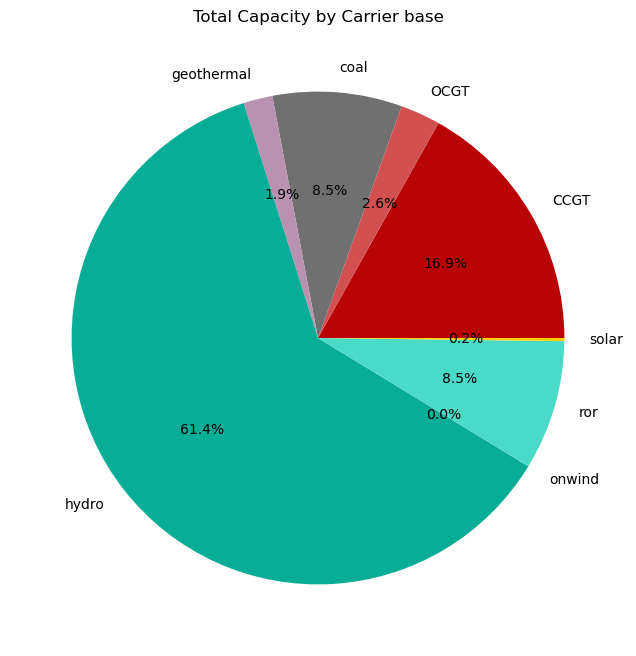

In [ ]:
# Combine generator and reservoir capacities
generator_capacity_by_carrier = (
    model.generators[model.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)

reservoir_capacity_by_carrier = (
    model.storage_units[model.storage_units.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)

# Combine both capacities into a single DataFrame
total_capacity_by_carrier = (
    pd.concat([generator_capacity_by_carrier, reservoir_capacity_by_carrier])
    .groupby(level=0)
    .sum()
)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_capacity_by_carrier,
    labels=total_capacity_by_carrier.index,
    autopct='%1.1f%%',
    colors=model.carriers[
        model.carriers.index.isin(total_capacity_by_carrier.index)
    ].color.reindex(total_capacity_by_carrier.index)
)
plt.title("Total Capacity by Carrier base")
plt.show()

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

C:\Users\hie\AppData\Local\Temp\ipykernel_21772\1467317455.py:167: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



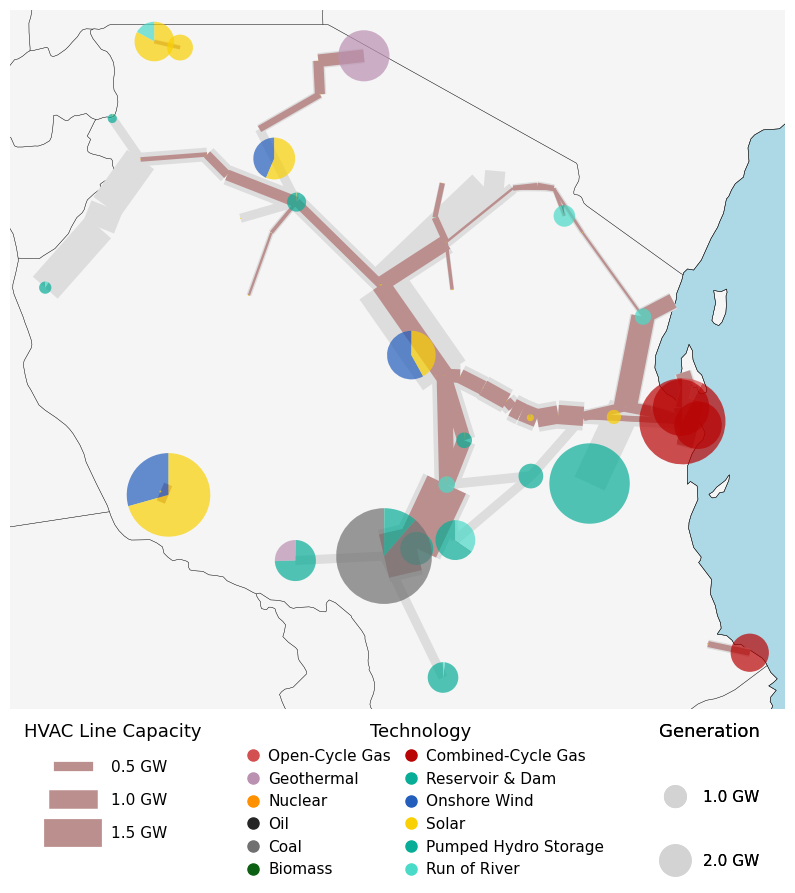

In [ ]:
#Optimised with line loadability

import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in model.carriers.index:
        model.carriers = model.carriers.drop("Load")

    # Filter model.carriers to only exclude "H2" and "batteries"
    filtered_carriers = model.carriers.loc[~model.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(model, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            model.generators.loc[model.generators.carrier != "load", fields],
            model.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(model.lines.s_nom_opt - model.lines.s_nom) / branch_factor
    link_widths = clip(model.links.p_nom_opt - model.links.p_nom) / branch_factor
    line_widths_opt = model.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    model.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    model.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = model.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = model.buses[~model.buses.index.str.contains(r"(H2|battery)$")]
    



    add_legend(ax, bus_factor, branch_factor)

    


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(model)

